In [1]:
"""
- ID3 (Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding 
      for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for 
      categorical targets. Trees are grown to their maximum size and then a pruning step is usually applied to improve 
      the ability of the tree to generalise to unseen data.

- C4.5 is the successor to ID3 and removed the restriction that features must be categorical by dynamically defining a 
      discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete 
      set of intervals. C4.5 converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules.
      These accuracy of each rule is then evaluated to determine the order in which they should be applied. Pruning is 
      done by removing a rule’s precondition if the accuracy of the rule improves without it.

- C5.0 is Quinlan’s latest version release under a proprietary license. It uses less memory and builds smaller rulesets 
      than C4.5 while being more accurate.

- CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical 
      target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and 
      threshold that yield the largest information gain at each node.

*** scikit-learn uses an optimised version of the CART algorithm ***
Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
"""

%matplotlib inline
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("error", category=UndefinedMetricWarning)
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from io import StringIO
from IPython.display import Image  
from collections import OrderedDict
import pydotplus
import pickle


def PlotTree(clf, features, name="Tree.png"):
    TextMode = export_text(clf, feature_names=features)
    print(TextMode)
    dot_data=StringIO()
    export_graphviz(clf, 
                    out_file=dot_data, 
                    filled=False, 
                    rounded=True, 
                    special_characters=True,
                    feature_names=features,
                    class_names=["False","True"], # ['0.0','1.0'], #The target classes in ascending numerical order
                    leaves_parallel=False,
                    impurity=False,
                    #proportion=True,
                    precision=2,
                    )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(name)
    return Image(graph.create_png())

def GetMetrics(y_test, y_pred):
    #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    display("confusion_matrix", pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)))
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    display("metrics", pd.DataFrame(report).transpose())


In [2]:
## Load Dataset to Train Model
Class=["REFACT"] # Target
system=["SYSTEM"]
features = [ "LOC", "NPM", "WMC", "NOC", "DIT", "CAM", "CBO", "RFC", "LCOM",
             "CA", "CE", "LCOM3", "DAM", "MOA", "MFA", "IC", "CBM", "AMC", ]
df = pd.read_csv('DatasetBalancedRefactFinal.csv', delimiter=",", decimal=".")
IndexRefact=df[df.REFACT==1.0].index
x = df[features] # Features
y = df[Class]    # Target of Model
print("Data Size: ",df.shape, 
      "Class 1.0 (Refact): ", len(df[df.REFACT==1.0]),     # PositiveClasses.csv 
      "Class 0.0 (not Refact): ", len(df[df.REFACT!=1.0]), # others
     )

display(df[features+Class].head())

print("** count summary of dataset by System and Class (Refact) **")
df[system+features[0:1]+Class].groupby(system+Class).agg(['count'])

Data Size:  (2096, 22) Class 1.0 (Refact):  1048 Class 0.0 (not Refact):  1048


,LOC,NPM,WMC,NOC,DIT,CAM,CBO,RFC,LCOM,CA,CE,LCOM3,DAM,MOA,MFA,IC,CBM,AMC,REFACT
0,27.0,6.0,6.0,0.0,2.0,0.5556,1.0,11.0,297,1.0,0.0,2.0000,0.000,0.0,0.5,1.0,1.0,3.50,0.0
1,27.0,6.0,6.0,0.0,2.0,0.5556,1.0,11.0,10,1.0,0.0,2.0000,0.000,0.0,0.5,1.0,1.0,3.50,0.0
2,150.0,2.0,2.0,0.0,1.0,0.6000,5.0,18.0,10,1.0,5.0,0.0000,1.000,2.0,0.0,0.0,0.0,72.00,0.0
3,65.0,3.0,3.0,0.0,1.0,0.8333,7.0,12.0,10,2.0,5.0,0.0000,1.000,1.0,0.0,0.0,0.0,20.00,0.0
4,126.0,7.0,8.0,0.0,0.0,0.5000,7.0,16.0,10,0.0,7.0,0.8571,0.625,1.0,0.0,0.0,0.0,13.75,0.0


** count summary of dataset by System and Class (Refact) **


LOC
              count
SYSTEM REFACT      
JMeter 0.0       53
       1.0       54
ant    0.0      106
       1.0       67
javacc 0.0        9
       1.0       11
jetty  0.0      214
       1.0      219
log4j  0.0       43
       1.0       46
lucene 0.0      129
       1.0      143
tomcat 0.0      375
       1.0      386
xerces 0.0      119
       1.0      122

In [3]:
## Find the best params for DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(random_state=0) # random_state - deterministic behaviour during fitting random_state has to be fixed to an integer
pipe = Pipeline(steps=[ ('dec_tree', dec_tree), ])
parameters = dict(dec_tree__criterion=['gini', 'entropy'],
                  dec_tree__min_samples_split=[16, 32, 64, 128, 256],
                  dec_tree__min_samples_leaf=[16, 32, 64, 128, 256],
                  dec_tree__max_depth=[2, 4, 6, 8, 10, 12, 14, 16, 18],
                  dec_tree__max_features=list(range(1,len(features)+1)),
                 )
scoring = {'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}
KF = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
Clf = GridSearchCV(pipe, param_grid=parameters, n_jobs=-1, cv=KF,
                   scoring=scoring, refit='f1', return_train_score=True
                   )

# split in Train_Validation (70%) and Test (30%) (train, test, validation: prevent overfitting)
x_train_validation_Refact, x_test_Refact, y_train_validation_Refact, y_test_Refact = train_test_split(
                                                                          x[x.index.isin(IndexRefact)], 
                                                                          y[y.index.isin(IndexRefact)], 
                                                                          test_size=0.3, random_state=0) 
x_train_validation_NonRefact, x_test_NonRefact, y_train_validation_NonRefact, y_test_NonRefact = train_test_split(
                                                                          x[~x.index.isin(IndexRefact)], 
                                                                          y[~y.index.isin(IndexRefact)], 
                                                                          test_size=0.3, random_state=0)
# To create balanced datasets
x_train_validation = pd.concat([x_train_validation_Refact, x_train_validation_NonRefact])
x_test = pd.concat([x_test_Refact, x_test_NonRefact])
y_train_validation = pd.concat([y_train_validation_Refact, y_train_validation_NonRefact])
y_test = pd.concat([y_test_Refact, y_test_NonRefact])

# KFold will split Train_Validation into 10-Folds: 9 to Train and 1 to Validation. 
# Next, GridSearchCV will find the best model
ClfFit=Clf.fit(x_train_validation, y_train_validation) 

# Save the Model
pickle.dump(Clf, open("OutputDecisionTree/DecisionTree", 'wb')) 

print("Decision tree tuning")
print("Best Parameters:\n\t Params: {}\n\t Score: {}\n".format(Clf.best_params_, Clf.best_score_))

print("--"*30)
print("** metrics for Train_Validation dataset **")
y_pred = ClfFit.predict(x_train_validation)
GetMetrics(y_train_validation, y_pred)

print("--"*30)
print("** metrics for Test dataset **")
y_pred = ClfFit.predict(x_test)
GetMetrics(y_test, y_pred)

print("--"*30)
img=PlotTree(Clf.best_estimator_.named_steps["dec_tree"], features, "OutputDecisionTree/DecisionTree.png")

Decision tree tuning
Best Parameters:
	 Params: {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 4, 'dec_tree__max_features': 12, 'dec_tree__min_samples_leaf': 16, 'dec_tree__min_samples_split': 16}
	 Score: 0.9783434517470712

------------------------------------------------------------
** metrics for Train_Validation dataset **


'confusion_matrix'

,0,1
0,716,17
1,15,718


'metrics'

,f1-score,precision,recall,support
0.0,0.978142,0.979480,0.976808,733.000000
1.0,0.978202,0.976871,0.979536,733.000000
accuracy,0.978172,0.978172,0.978172,0.978172
macro avg,0.978172,0.978175,0.978172,1466.000000
weighted avg,0.978172,0.978175,0.978172,1466.000000


------------------------------------------------------------
** metrics for Test dataset **


'confusion_matrix'

,0,1
0,308,7
1,11,304


'metrics'

,f1-score,precision,recall,support
0.0,0.971609,0.965517,0.977778,315.000000
1.0,0.971246,0.977492,0.965079,315.000000
accuracy,0.971429,0.971429,0.971429,0.971429
macro avg,0.971427,0.971505,0.971429,630.000000
weighted avg,0.971427,0.971505,0.971429,630.000000


------------------------------------------------------------
|--- LCOM <= 27.50
|   |--- LCOM <= 18.50
|   |   |--- class: 0.0
|   |--- LCOM >  18.50
|   |   |--- WMC <= 6.50
|   |   |   |--- class: 0.0
|   |   |--- WMC >  6.50
|   |   |   |--- CBO <= 8.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- CBO >  8.50
|   |   |   |   |--- class: 1.0
|--- LCOM >  27.50
|   |--- WMC <= 8.50
|   |   |--- WMC <= 6.50
|   |   |   |--- class: 0.0
|   |   |--- WMC >  6.50
|   |   |   |--- class: 0.0
|   |--- WMC >  8.50
|   |   |--- AMC <= 22743.47
|   |   |   |--- WMC <= 11.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- WMC >  11.50
|   |   |   |   |--- class: 1.0
|   |   |--- AMC >  22743.47
|   |   |   |--- class: 0.0



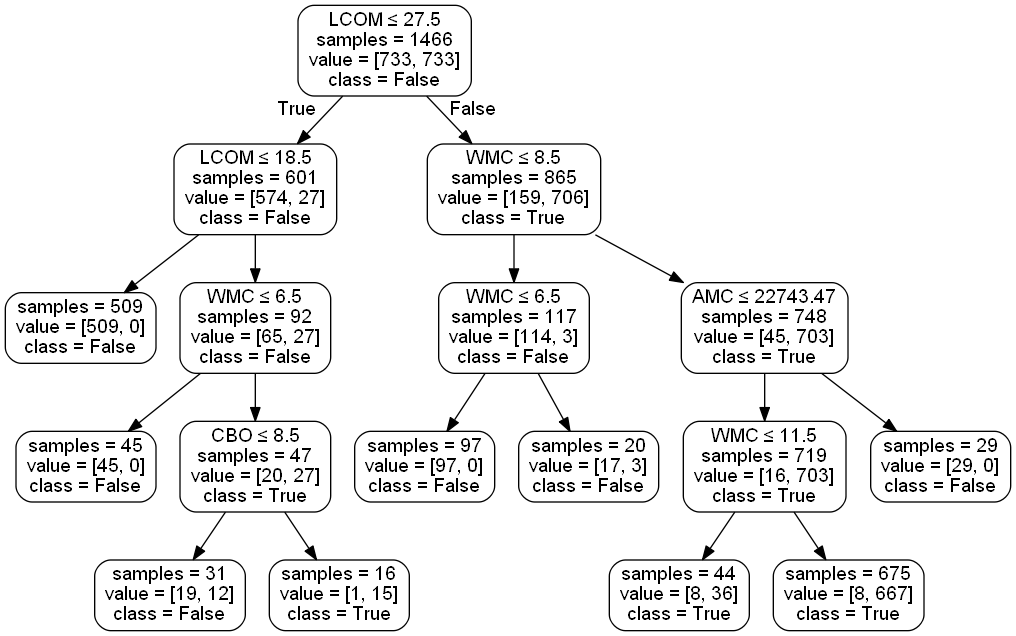

In [4]:
img

In [5]:
TrainParmResults=pd.DataFrame(Clf.cv_results_)
pd.options.display.max_columns = None
TrainParmResults = TrainParmResults.sort_values(by =['rank_test_f1', 
                                                     "param_dec_tree__max_depth",
                                                     "param_dec_tree__max_features",
                                                     "param_dec_tree__min_samples_leaf",
                                                     "param_dec_tree__min_samples_split"] , 
                                                ascending=True)
TrainParmResults.head(8) # -1 Show all 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dec_tree__criterion,param_dec_tree__max_depth,param_dec_tree__max_features,param_dec_tree__min_samples_leaf,param_dec_tree__min_samples_split,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,split7_test_f1,split8_test_f1,split9_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,split5_train_f1,split6_train_f1,split7_train_f1,split8_train_f1,split9_train_f1,mean_train_f1,std_train_f1,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,split5_test_precision,split6_test_precision,split7_test_precision,split8_test_precision,split9_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,split5_train_precision,split6_train_precision,split7_train_precision,split8_train_precision,split9_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,split5_test_recall,split6_test_recall,split7_test_recall,split8_test_recall,split9_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,split5_train_recall,split6_train_recall,split7_train_recall,split8_train_recall,split9_train_recall,mean_train_recall,std_train_recall
725,0.009066,0.002422,0.013726,0.010331,gini,4,12,16,16,"{'dec_tree__criterion': 'gini', 'dec_tree__max...",0.973684,0.986486,0.97931,0.951724,0.986486,0.966887,1.0,0.986111,0.966443,0.986301,0.978343,0.013151,1,0.97882,0.977376,0.978179,0.981104,0.977376,0.979592,0.975794,0.977444,0.979623,0.97741,0.978272,0.001452,0.948718,0.986486,1.0,0.958333,0.973333,0.935897,1.0,1.0,0.947368,0.986301,0.973644,0.023195,328,0.975867,0.971514,0.970149,0.978884,0.972973,0.977376,0.97432,0.970149,0.97594,0.971557,0.973873,0.002921,1.0,0.986486,0.959459,0.945205,1.0,1.0,1.0,0.972603,0.986301,0.986301,0.983636,0.018101,263,0.981791,0.983308,0.986343,0.983333,0.981818,0.981818,0.977273,0.984848,0.983333,0.983333,0.98272,0.002265
726,0.012301,0.003973,0.008666,0.002999,gini,4,12,16,32,"{'dec_tree__criterion': 'gini', 'dec_tree__max...",0.973684,0.986486,0.97931,0.951724,0.986486,0.966887,1.0,0.986111,0.966443,0.986301,0.978343,0.013151,1,0.97882,0.977376,0.978179,0.981104,0.977376,0.979592,0.975794,0.977444,0.979623,0.97741,0.978272,0.001452,0.948718,0.986486,1.0,0.958333,0.973333,0.935897,1.0,1.0,0.947368,0.986301,0.973644,0.023195,328,0.975867,0.971514,0.970149,0.978884,0.972973,0.977376,0.97432,0.970149,0.97594,0.971557,0.973873,0.002921,1.0,0.986486,0.959459,0.945205,1.0,1.0,1.0,0.972603,0.986301,0.986301,0.983636,0.018101,263,0.981791,0.983308,0.986343,0.983333,0.981818,0.981818,0.977273,0.984848,0.983333,0.983333,0.98272,0.002265
800,0.012084,0.006178,0.007854,0.005724,gini,4,15,16,16,"{'dec_tree__criterion': 'gini', 'dec_tree__max...",0.973684,0.986486,0.97931,0.951724,0.986486,0.966887,1.0,0.986111,0.966443,0.986301,0.978343,0.013151,1,0.97882,0.977376,0.978179,0.981104,0.977376,0.979592,0.975794,0.977444,0.979623,0.97741,0.978272,0.001452,0.948718,0.986486,1.0,0.958333,0.973333,0.935897,1.0,1.0,0.947368,0.986301,0.973644,0.023195,328,0.975867,0.971514,0.970149,0.978884,0.972973,0.977376,0.97432,0.970149,0.97594,0.971557,0.973873,0.002921,1.0,0.986486,0.959459,0.945205,1.0,1.0,1.0,0.972603,0.986301,0.986301,0.983636,0.018101,263,0.981791,0.983308,0.986343,0.983333,0.981818,0.981818,0.977273,0.984848,0.983333,0.983333,0.98272,0.002265
801,0.009672,0.000818,0.007045,0.003388,gini,4,15,16,32,"{'dec_tree__criterion': 'gini', 'dec_tree__max...",0.973684,0.986486,0.97931,0.951724,0.986486,0.966887,1.0,0.986111,0.966443,0.986301,0.978343,0.013151,1,0.97882,0.9773

In [6]:
print("** metrics for Test dataset grouped by each system **")
df_test=df[df.index.isin(x_test.index)]
#display(df_test[system+features[0:1]+Class].groupby(system+Class).agg(['count']))
for sys in df_test.SYSTEM.unique():
    print("System: ",sys)
    y_pred = ClfFit.predict(df_test[df_test.SYSTEM==sys][features])
    GetMetrics(df_test[df_test.SYSTEM==sys][Class], y_pred)


** metrics for Test dataset grouped by each system **
System:  log4j


'confusion_matrix'

,0,1
0,14,2
1,0,17


'metrics'

,f1-score,precision,recall,support
0.0,0.933333,1.000000,0.875000,16.000000
1.0,0.944444,0.894737,1.000000,17.000000
accuracy,0.939394,0.939394,0.939394,0.939394
macro avg,0.938889,0.947368,0.937500,33.000000
weighted avg,0.939057,0.945774,0.939394,33.000000


System:  xerces


'confusion_matrix'

,0,1
0,24,1
1,1,34


'metrics'

,f1-score,precision,recall,support
0.0,0.960000,0.960000,0.960000,25.000000
1.0,0.971429,0.971429,0.971429,35.000000
accuracy,0.966667,0.966667,0.966667,0.966667
macro avg,0.965714,0.965714,0.965714,60.000000
weighted avg,0.966667,0.966667,0.966667,60.000000


System:  lucene


'confusion_matrix'

,0,1
0,34,1
1,2,46


'metrics'

,f1-score,precision,recall,support
0.0,0.957746,0.944444,0.971429,35.000000
1.0,0.968421,0.978723,0.958333,48.000000
accuracy,0.963855,0.963855,0.963855,0.963855
macro avg,0.963084,0.961584,0.964881,83.000000
weighted avg,0.963920,0.964268,0.963855,83.000000


System:  JMeter


'confusion_matrix'

,0,1
0,16,0
1,2,12


'metrics'

,f1-score,precision,recall,support
0.0,0.941176,0.888889,1.000000,16.000000
1.0,0.923077,1.000000,0.857143,14.000000
accuracy,0.933333,0.933333,0.933333,0.933333
macro avg,0.932127,0.944444,0.928571,30.000000
weighted avg,0.932730,0.940741,0.933333,30.000000


System:  ant


'confusion_matrix'

,0,1
0,31,1
1,2,21


'metrics'

,f1-score,precision,recall,support
0.0,0.953846,0.939394,0.968750,32.000000
1.0,0.933333,0.954545,0.913043,23.000000
accuracy,0.945455,0.945455,0.945455,0.945455
macro avg,0.943590,0.946970,0.940897,55.000000
weighted avg,0.945268,0.945730,0.945455,55.000000


System:  javacc


'confusion_matrix'

,0,1
0,4,0
1,0,2


'metrics'

,f1-score,precision,recall,support
0.0,1.0,1.0,1.0,4.0
1.0,1.0,1.0,1.0,2.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,6.0
weighted avg,1.0,1.0,1.0,6.0


System:  jetty


'confusion_matrix'

,0,1
0,62,1
1,2,51


'metrics'

,f1-score,precision,recall,support
0.0,0.976378,0.968750,0.984127,63.000000
1.0,0.971429,0.980769,0.962264,53.000000
accuracy,0.974138,0.974138,0.974138,0.974138
macro avg,0.973903,0.974760,0.973196,116.000000
weighted avg,0.974117,0.974242,0.974138,116.000000


System:  tomcat


'confusion_matrix'

,0,1
0,123,1
1,2,121


'metrics'

,f1-score,precision,recall,support
0.0,0.987952,0.984000,0.991935,124.000000
1.0,0.987755,0.991803,0.983740,123.000000
accuracy,0.987854,0.987854,0.987854,0.987854
macro avg,0.987853,0.987902,0.987838,247.000000
weighted avg,0.987854,0.987886,0.987854,247.000000
